Random Seed:  999
DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4

/home/stud1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stud1/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 53.545845
[1/1000][0/40]	Loss_D: 0.0434	Loss_G: 10.6553	D(x): 0.9604	D(G(z)): 0.1890 / 0.0000
[1/1000][39/40]	Loss_D: 0.0995	Loss_G: 30.6589	D(x): 0.7977	D(G(z)): 0.0000 / 0.0000
Inception Score: 12.548233
[2/1000][0/40]	Loss_D: 0.0790	Loss_G: 32.2740	D(x): 0.8629	D(G(z)): 0.0000 / 0.0000
[2/1000][39/40]	Loss_D: 0.2639	Loss_G: 33.1039	D(x): 0.5759	D(G(z)): 0.0000 / 0.0000
Inception Score: 4.8727303
[3/1000][0/40]	Loss_D: 0.0630	Loss_G: 33.0950	D(x): 0.8841	D(G(z)): 0.0000 / 0.0000
[3/1000][39/40]	Loss_D: 0.0186	Loss_G: 7.4715	D(x): 0.9909	D(G(z)): 0.0004 / 0.0004
Inception Score: 93.996864
[4/1000][0/40]	Loss_D: 0.7284	Loss_G: 14.5454	D(x): 0.9885	D(G(z)): 0.9479 / 0.0000
[4/1000][39/40]	Loss_D: 0.0571	Loss_G: 5.5302	D(x): 0.8629	D(G(z)): 0.0018 / 0.0024
Inception Score: 8.89214
[5/1000][0/40]	Loss_D: 0.0495	Loss_G: 13.6436	D(x): 0.9550	D(G(z)): 0.2848 / 0.0000
[5/1000][39/40]	Loss_D: 0.1305	Loss_G: 6.1380	D(x): 0.9320	D(G(z)): 0.3812 / 0.0088
Inception Score: 15.58977

MovieWriter stderr:
convert-im6.q16: no images defined `b_128_i_128_gan_bm_1000.gif' @ error/convert.c/ConvertImageCommand/3258.



CalledProcessError: Command '['convert', '-size', '576x576', '-depth', '8', '-delay', '100.0', '-loop', '0', 'rgba:-', 'b_128_i_128_gan_bm_1000.gif']' returned non-zero exit status 1.

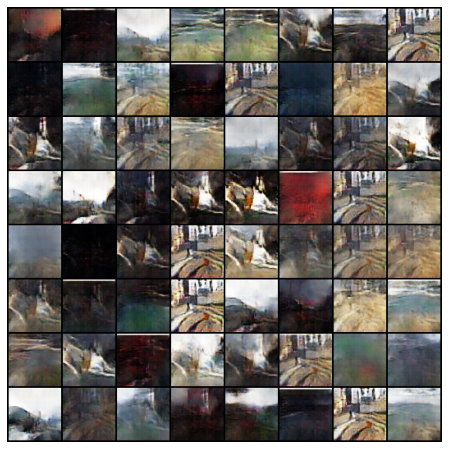

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torchvision.models as models
#torch.cuda.set_device(2)
#torch.cuda.empty_cache()
#set CUDA_VISIBLE_DEVICES='1'
#from IPython.display import HTML
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
def inception_score(imgs,device,batch_size=64, resize=True, splits=1):
    # Convert NumPy array to PyTorch tensor
    #imgs_tensor = torch.from_numpy(imgs)

    # Move the tensor to the desired device
    #imgs_tensor = imgs_tensor.to(device)
    imgs = imgs.to(device)
    #imgs = imgs_tensor
    N = imgs.size(0)
    if resize:
        imgs = nn.functional.interpolate(imgs, size=(299, 299), mode='bilinear', align_corners=False)
    #imgs = imgs.repeat(1, 3, 1, 1)  # Convert grayscale to RGB

    inception_model = models.inception_v3(pretrained=True, transform_input=False).eval().to(device)
    up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=False).to(device)

    scores = []
    for i in range(0, N, batch_size):
        batch = imgs[i:i + batch_size]
        batch = up(batch)
        logits = inception_model(batch)
        probs = torch.softmax(logits, dim=1)
        kl = probs * (torch.log(probs) - torch.log(torch.tensor(1.0 / probs.size(1)).to(device)))
        kl = kl.sum(1)
        scores.append(kl.cpu().numpy())

    scores = np.concatenate(scores)
    scores = np.exp(scores.mean())

    if splits > 1:
        kl = probs * (torch.log(probs) - torch.log(torch.tensor(1.0 / probs.size(1)).to(device)))
        kl = kl.sum(1).detach().cpu().numpy()
        split_scores = []
        for k in range(splits):
            part = kl[k * (N // splits): (k + 1) * (N // splits)]
            py = np.exp(part.mean())
            split_scores.append(py)
        return scores, np.std(split_scores)

    return scores




# Root directory for dataset
dataroot = "/home/stud1/Aman/dataset"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size =64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf =64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2
# We can use an image folder dataset the way we have it setup.
# Create the dataset
# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize((image_size,image_size)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

#Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig('training_images.png')
plt.close()
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf *8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
#             nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf*2),
#             nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
        
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
#             nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf * 16),
#             nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
# Initialize BCELoss function
criterion_D = nn.BCELoss()
criterion_G = nn.BCELoss()


# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
i_score=[]

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion_D(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion_D(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion_G(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 39 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 39 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                vutils.save_image(fake, 'F_b_128_i_128_gan_progress_bm_1000.png', normalize=True)
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        fake_images = vutils.make_grid(fake, normalize=True).numpy()
        inception_score_value= inception_score(fake,device, batch_size=32, resize=True, splits=1)
        print("Inception Score:", inception_score_value)
        i_score.append(inception_score_value)


        
        
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('b_128_i_128_gan_bm_1000.png')
plt.close()

epochs_ = list(range(1, len(i_score) + 1))
plt.plot(epochs_, i_score, marker='o')  # 'o' for circular markers
plt.xlabel('Epochs')
plt.ylabel('Inception Score')
plt.title('Inception Score over Epochs')
plt.grid(True)
plt.savefig('b_128_i_128_bm_1000.png')
plt.close()

with open('inception_scores_bm_1000.txt', 'w') as file:
    # Write each inception score to a new line in the file
    for score in i_score:
        file.write(str(score) + '\n')


import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('b_128_i_128_gan_bm_1000.gif', writer='imagemagick')  # For GIF format
plt.close()

# Display the animation
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig('R_vs_F_b_128_i_128_gan_bm_1000.png')
plt.close()


In [2]:
with torch.no_grad():
    fixed_noise = torch.randn(1, nz, 1, 1, device=device)
    fake = netG(fixed_noise).detach().cpu()
    vutils.save_image(fake, 'F_b_128_i_128_gan_progress_mb__1000.png', normalize=True)
